In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Layer, Dropout
from keras.models import Model
from keras.initializers import glorot_normal

Using TensorFlow backend.


In [2]:
sns.set_style("white")
test_ratio = 0.1
data_step = 0.005
data_sigma1 = 2
data_sigma2 = 1
def func(x):
    return np.power(x, 3)

num_data= 1201

data_x = np.linspace(-3, 3, num_data)
data_y = np.zeros(num_data)
data_y_true = np.zeros(num_data)

In [3]:
for i in range(num_data):
    if (data_x[i] < 0):  # -3 <= x <0, sigma=2 (has more uncertainty inherently)
        data_y[i] = func(data_x[i]) + np.random.normal(0, data_sigma1)
    else:  # x>0, sigma=1 (less noisy measurement)
        data_y[i] = func(data_x[i]) + np.random.normal(0, data_sigma2)
        
    data_y_true[i] = func(data_x[i])

In [6]:
num_train_data = int(num_data * (1 - test_ratio))
num_test_data  = num_data - num_train_data

data_x = np.reshape(data_x, [num_data, 1])
data_y = np.reshape(data_y, [num_data, 1])
data_y_true = np.reshape(data_y_true, [num_data, 1])

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

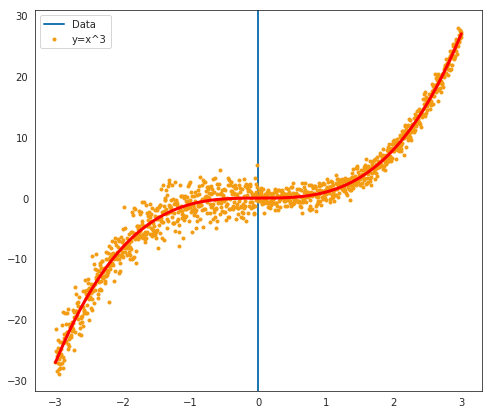

In [7]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x, data_y, '.', markersize=6, color='#F39C12')
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [14]:
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.log(sigma) + 0.5*tf.div(tf.square(y_true - y_pred), sigma)) + 1e-6
    return gaussian_loss

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.autograd import Variable

In [11]:
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.w_1 = self.add_weight(name='kernel_1', 
                                      shape=(30, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.w_2 = self.add_weight(name='kernel_2', 
                                      shape=(30, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.b_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.b_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.w_1) + self.b_1   # output mu
        output_sig = K.dot(x, self.w_2) + self.b_2   # output sigma
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  # always being positive
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [12]:
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

In [15]:
inputs = Input(shape=(1,))
x = Dense(10, activation='relu')(inputs)
x = Dense(6, activation='relu')(x)
x = Dense(30, activation='relu')(x)
mu, sigma = GaussianLayer(output_dim=1, name='main_output')(x)
model = Model(inputs, mu)
model.compile(loss=custom_loss(sigma), optimizer='adam')
model.fit(train_x, train_y, epochs=300, verbose=1)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Epoch 1/300
1080/1080 [==============================] - 0s 213us/step - loss: 261.3148
Epoch 2/300
1080/1080 [==============================] - 0s 39us/step - loss: 126.2519
Epoch 3/300
1080/1080 [==============================] - 0s 44us/step - loss: 51.6159
Epoch 4/300
1080/1080 [==============================] - 0s 37us/step - loss: 27.1117
Epoch 5/300
1080/1080 [==============================] - 0s 36us/step - loss: 17.6709
Epoch 6/300
1080/1080 [==============================] - 0s 35us/step - loss: 13.2464
Epoch 7/300
1080/1080 [==============================] - 0s 37us/step - loss: 10.7228
Epoch 8/300
1080/1080 [==============================] - 0s 39us/step - loss: 8.2502
Epoch 9/300
1080/1080 [==============================] - 0s 36us/step - loss: 6.7727
Epoch 10/300
1080/1080 [==============================] - 0s 36us/step - loss: 5.8957
Epoch 11/300
1080/1080 [==============================] - 0s

Epoch 91/300
1080/1080 [==============================] - 0s 39us/step - loss: 1.4239
Epoch 92/300
1080/1080 [==============================] - 0s 34us/step - loss: 1.4133
Epoch 93/300
1080/1080 [==============================] - 0s 34us/step - loss: 1.4015
Epoch 94/300
1080/1080 [==============================] - 0s 36us/step - loss: 1.3908
Epoch 95/300
1080/1080 [==============================] - 0s 37us/step - loss: 1.3803
Epoch 96/300
1080/1080 [==============================] - 0s 40us/step - loss: 1.3673
Epoch 97/300
1080/1080 [==============================] - 0s 35us/step - loss: 1.3567
Epoch 98/300
1080/1080 [==============================] - 0s 35us/step - loss: 1.3469
Epoch 99/300
1080/1080 [==============================] - 0s 36us/step - loss: 1.3364
Epoch 100/300
1080/1080 [==============================] - 0s 37us/step - loss: 1.3282
Epoch 101/300
1080/1080 [==============================] - 0s 39us/step - loss: 1.3177
Epoch 102/300
1080/1080 [===========================

1080/1080 [==============================] - 0s 38us/step - loss: 1.0011
Epoch 186/300
1080/1080 [==============================] - 0s 30us/step - loss: 0.9995
Epoch 187/300
1080/1080 [==============================] - 0s 35us/step - loss: 1.0043
Epoch 188/300
1080/1080 [==============================] - 0s 36us/step - loss: 0.9974
Epoch 189/300
1080/1080 [==============================] - 0s 39us/step - loss: 0.9965
Epoch 190/300
1080/1080 [==============================] - 0s 34us/step - loss: 1.0007
Epoch 191/300
1080/1080 [==============================] - 0s 35us/step - loss: 0.9990
Epoch 192/300
1080/1080 [==============================] - 0s 37us/step - loss: 0.9985
Epoch 193/300
1080/1080 [==============================] - 0s 32us/step - loss: 0.9940
Epoch 194/300
1080/1080 [==============================] - 0s 35us/step - loss: 0.9949
Epoch 195/300
1080/1080 [==============================] - 0s 38us/step - loss: 0.9980
Epoch 196/300
1080/1080 [==============================] 

1080/1080 [==============================] - 0s 32us/step - loss: 0.9530
Epoch 280/300
1080/1080 [==============================] - 0s 32us/step - loss: 0.9601
Epoch 281/300
1080/1080 [==============================] - 0s 38us/step - loss: 0.9527
Epoch 282/300
1080/1080 [==============================] - 0s 43us/step - loss: 0.9481
Epoch 283/300
1080/1080 [==============================] - 0s 37us/step - loss: 0.9511
Epoch 284/300
1080/1080 [==============================] - 0s 36us/step - loss: 0.9557
Epoch 285/300
1080/1080 [==============================] - 0s 35us/step - loss: 0.9441
Epoch 286/300
1080/1080 [==============================] - 0s 39us/step - loss: 0.9469
Epoch 287/300
1080/1080 [==============================] - 0s 35us/step - loss: 0.9432
Epoch 288/300
1080/1080 [==============================] - 0s 36us/step - loss: 0.9474
Epoch 289/300
1080/1080 [==============================] - 0s 41us/step - loss: 0.9463
Epoch 290/300
1080/1080 [==============================] 

In [18]:
# Define a new function named 'get_intermediate'

layer_name = 'main_output' # Where to extract the Gaussian output from. 
get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

In [19]:
preds, sigmas = [], []
for j in range(len(train_x)):
    mu, sigma = get_intermediate([[train_x[j]]])
    preds.append(mu.reshape(1,)[0])
    sigmas.append(sigma.reshape(1,)[0])
plt.figure(1, figsize=(15, 9))
plt.plot([i[0] for i in train_x], [i for i in train_y])
plt.plot([i[0] for i in train_x], [i for i in preds], 'b', linewidth=3)
upper = [i+k for i,k in zip(preds, sigmas)]
lower = [i-k for i,k in zip(preds, sigmas)]
plt.plot([i[0] for i in train_x], [i for i in upper], 'r', linewidth = 3)
plt.plot([i[0] for i in train_x], [i for i in lower], 'r', linewidth = 3)
plt.plot([i[0] for i in train_x], [func(i[0]) for i in train_x], 'y', linewidth = 2)
plt.show()

InvalidArgumentError: In[0] is not a matrix. Instead it has shape [1]
	 [[{{node dense_4/Relu}}]]

In [20]:
x_ax = np.linspace(-4, 4, num=200)
preds, sigmas = [], []
for j in range(len(x_ax)):
    
    mu, sigma = get_intermediate([[np.array([x_ax[j]])]])
    preds.append(mu.reshape(1,)[0])
    sigmas.append(sigma.reshape(1,)[0])
plt.figure(1, figsize=(15, 9))
plt.plot([i for i in x_ax], [i for i in preds], 'b', linewidth=3)
upper = [i+k for i,k in zip(preds, sigmas)]
lower = [i-k for i,k in zip(preds, sigmas)]
plt.plot([i for i in x_ax], [i for i in upper], 'r', linewidth = 3)
plt.plot([i for i in x_ax], [i for i in lower], 'r', linewidth = 3)
plt.plot([i for i in x_ax], [func(i) for i in x_ax], 'y', linewidth = 2)
plt.show()

InvalidArgumentError: In[0] is not a matrix. Instead it has shape [1]
	 [[{{node dense_4/Relu}}]]